<a href="https://colab.research.google.com/github/nsp8/Machine-Learning-Resources/blob/colab-ml-practice/Image_Classification_Batch_Inference_(PyTorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification Batch Inference with PyTorch
---
Using Ray Data for large-scale batch inference with multiple GPUs


1. Load "Imagenette" dataset from S3
2. Create Ray Dataset
3. Load pre-trained ResNet model
4. Ray data to preprocess dataset
5. Perform model inference, parallelizing across multiple GPUs
6. Evaluate predictions and save results to S3




In [2]:
!pip install -q "ray[data]" torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 70.7 MB/s eta 0:00:00


In [3]:
import ray

s3_uri = "s3://anonymous@air-example-data-2/imagenette2/train/"
dataset = ray.data.read_images(s3_uri, mode="RGB")

2024-07-14 06:33:10,011	INFO worker.py:1788 -- Started a local Ray instance.


In [3]:
dataset.schema()

2024-07-13 13:09:21,218	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-13_13-09-14_831907_309/logs/ray-data
2024-07-13 13:09:21,219	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage]


- ReadImage 1:   0%|          | 0/200 [00:00<?, ?it/s]

Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

Column  Type
------  ----
image   numpy.ndarray(ndim=3, dtype=uint8)

In [ ]:
from PIL import Image

single_batch = dataset.take_batch(10)
image = Image.fromarray(single_batch["image"][0])

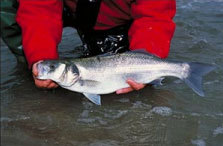

In [5]:
image

## Load(ResNet model) -> Get(PreProcessing Transforms) -> PreProcess(Images)

In [25]:
from PIL import Image
import torch
from torchvision.models import ResNet152_Weights
from torchvision import transforms
from torchvision import models
import ray


class ImageClassifier:
    def __init__(self, data_source: str):
        self.dataset = ray.data.read_images(data_source, mode="RGB")
        self.weights = ResNet152_Weights.IMAGENET1K_V1
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.create_model()

    @property
    def imagenet_transforms(self):
        return self.weights.transforms

    @property
    def transform(self):
        return transforms.Compose([transforms.ToTensor(), self.imagenet_transforms()])

    def create_model(self):
        model = models.resnet152(weights=self.weights).to(self.device)
        model.eval()
        return model

    def get_data_batch(self, batch_size):
        return self.dataset.take_batch(batch_size)

    def show_sample_image(self, batch_size):
        return Image.fromarray(self.get_data_batch(batch_size)["image"][0])

    def predict(self, batch_size=10, dealloc_model_on_completion=True):
        if self.model is None:
            self.model = self.create_model()
        transformed_batch = [self.transform(image) for image in self.get_data_batch(batch_size)["image"]]
        with torch.inference_mode():
            prediction_results = self.model(torch.stack(transformed_batch).to(self.device))
            classes = prediction_results.argmax(dim=1).cpu()
        predicted_labels = [self.weights.meta["categories"][i] for i in classes]
        if dealloc_model_on_completion:
            self.model = None
        return predicted_labels


In [26]:
image_classifier = ImageClassifier(data_source=s3_uri)
predictions = image_classifier.predict()

2024-07-14 07:05:24,064	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-14_06-33-06_498707_516/logs/ray-data
2024-07-14 07:05:24,066	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage] -> LimitOperator[limit=10]


- ReadImage 1:   0%|          | 0/200 [00:00<?, ?it/s]

- limit=10 2:   0%|          | 0/200 [00:00<?, ?it/s]

Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

In [27]:
predictions

['coho',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'bittern',
 'tench',
 'tench']

## Scaling up to complete dataset using Ray

In [30]:
import numpy as np


class ResNetModel:
    def __init__(self):
        self.weights = ResNet152_Weights.IMAGENET1K_V1
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = models.resnet152(weights=self.weights).to(self.device)
        self.model.eval()

    def __call__(self, batch: dict[str, np.ndarray]):
        batch = torch.from_numpy(batch["transformed_image"]).to(self.device)
        with torch.inference_mode():
            prediction = self.model(batch)
            predicted_classes = prediction.argmax(dim=1).detach().cpu()
            predicted_labels = [
                self.weights.meta["categories"][i] for i in predicted_classes
            ]
            return {
                "predicted_label": predicted_labels,
                "original_image": batch["original_image"]
            }


def preprocess_image(row: dict[str, np.ndarray]):
    return {
        "original_image": row["image"],
        "transformed_iamge": image_classifier.transform(row["image"])
    }


In [33]:
def predict_using_ray_data_processing(num_gpus=4, gpus_per_model_replica=1, batch_size=720):
    transformed_dataset = image_classifier.dataset.map(preprocess_image)
    predictions = transformed_dataset.map_batches(
        ResNetModel,
        concurrency=num_gpus,
        num_gpus=gpus_per_model_replica,
        batch_size=batch_size
    )
    return predictions

In [36]:
predictions = predict_using_ray_data_processing()

In [ ]:
prediction_batch = predictions.take_batch(5)

In [ ]:
def visualize_results(prediction_batch):
    for image, prediction in zip(
        prediction_batch["original_image"],
        prediction_batch["predicted_label"],
    ):
        _image = Image.fromarray(image)
        _image.show()
        print(f"Label: {prediction}")


visualize_results(prediction_batch)